In [1]:
#Instructions
#Download Crime_Reports.csv
#Use csv_cleaner to change O labels to N and get 80/20 split (TODO) for training/test data
#Run cells sequentially
#Clean data below
#Make sure all names match up

In [2]:
# Avner Khan, Kiran Raja, Abhishek Khare, Joshua Deng
import matplotlib.pyplot as plt
from amb_sdk.sdk import DarwinSdk
from time import sleep
import pandas as pd
import numpy as np
import sklearn.model_selection as ms
from sklearn.metrics import classification_report
import datetime

ds = DarwinSdk()
ds.set_url('https://amb-demo-api.sparkcognition.com/v1/')
ts = '{:%Y%m%d%H%M%S}'.format(datetime.datetime.now())


In [3]:

#Create a new user
status, msg = ds.auth_login_user('AVNERKHAN@UTEXAS.edu', 'xcGPvw7VMm')
if not status:
    print(msg)
print(status)

True


In [21]:
def elapsed_time(oc_date, oc_time, rep_date, rep_time):
    oc_date_split_arr = oc_date.split("/")
    oc_date_month = oc_date_split_arr[0]
    oc_date_day = oc_date_split_arr[1]
    oc_date_year = oc_date_split_arr[2]
    oc_hr = int(oc_time // 100)
    if (oc_hr > 23):
        oc_hr = 23
    elif (oc_hr < 0):
        oc_hr = 0
    oc_min = int(oc_time % 100)
    if (oc_min > 59):
        oc_min = 59
    elif (oc_min < 0):
        oc_min = 0
    oc_datetime = datetime.datetime(int(oc_date_year), int(oc_date_month), int(oc_date_day), oc_hr, oc_min)
    rep_date_split_arr = rep_date.split("/")
    rep_date_month = rep_date_split_arr[0]
    rep_date_day = rep_date_split_arr[1]
    rep_date_year = rep_date_split_arr[2]
    rep_hr = int(rep_time // 100)
    if (rep_hr > 23):
        rep_hr = 23
    elif (rep_hr < 0):
        rep_hr = 0
    rep_min = int(rep_time % 100)
    if (rep_min > 59):
        rep_min = 59
    elif (rep_min < 0):
        rep_min = 0
    rep_datetime = datetime.datetime(int(rep_date_year), int(rep_date_month), int(rep_date_day), rep_hr, rep_min)
    elapsed = rep_datetime - oc_datetime
    return elapsed.total_seconds() / 3600

dataset = pd.read_csv("Crime_Reports_Fixed.csv")
# print(len(dataset))
dataset = dataset.drop(columns=['Location', 'Category Description', 'UCR Category', 'PRA', 'APD Sector', 'APD District', 'Council District', 'Zip Code', 'Address', 'Incident Number', 'Highest Offense Description', 'Occurred Date Time', 'Report Date Time', 'Clearance Date', 'X-coordinate', 'Y-coordinate', 'Latitude', 'Longitude'])
# print(dataset.head())
dataset = dataset.dropna()
elapsed = []
for index, row in dataset.iterrows():
#     if (row['Clearance Status'] != 'C'):
#         dataset.loc[index, 'Clearance Status'] = 'N'
    elapsed.append(elapsed_time(row['Occurred Date'], row['Occurred Time'], row['Report Date'], row['Report Time']))
elapsed_df = pd.DataFrame(data=elapsed)
dataset['Elapsed Time'] = elapsed_df
dataset = dataset.drop(columns=['Occurred Date', 'Occurred Time', 'Report Date', 'Report Time'])
print(len(dataset))
print(dataset.head())
dataset.to_csv('Cleaned_Crime_Reports_Full_2.csv') # Actual TRAINING Data

1516122
   Highest Offense Code Family Violence                 Location Type  \
0                  2716               N        GAS / SERVICE STATIONS   
1                   600               N              RESIDENCE / HOME   
2                   300               N  STREETS / HWY / ROAD / ALLEY   
4                  1803               N  STREETS / HWY / ROAD / ALLEY   
6                   601               N         PARKING LOTS / GARAGE   

   Census Tract Clearance Status  Elapsed Time  
0         11.00                C      0.250000  
1         21.07                N    213.783333  
2         18.04                N      0.000000  
4          7.00                C     11.216667  
6         11.00                N     75.283333  


In [4]:
status, message = ds.delete_dataset("Cleaned_Crime_Reports_Full_2.csv")
print(status, message)

True None


In [16]:
#Split Train and Test Data
dataset = pd.read_csv("Cleaned_Crime_Reports_Full_2.csv")
dataset = dataset.drop(dataset.columns[0], axis=1)
dataset = dataset.sample(frac=1)
train_data = dataset.iloc[:int(len(dataset)*.8)]
test_data = dataset.iloc[int(len(dataset)*.8):]
print(train_data.head())
print(test_data.head())
train_data.to_csv("Cleaned_Crime_Reports_Train.csv")
test_data.to_csv("Cleaned_Crime_Reports_Test.csv")

         Highest Offense Code Family Violence                 Location Type  \
729732                   2008               N              RESIDENCE / HOME   
261916                   2010               N         PARKING LOTS / GARAGE   
1203836                  1199               N              RESIDENCE / HOME   
706689                    902               Y              RESIDENCE / HOME   
1030200                  2406               N  STREETS / HWY / ROAD / ALLEY   

         Census Tract Clearance Status  Elapsed Time  
729732          13.05                N      0.966667  
261916          20.05                N    120.316667  
1203836         24.27                N           NaN  
706689          23.04                N      2.033333  
1030200         11.00                C      0.000000  
         Highest Offense Code Family Violence                 Location Type  \
293387                   2707               N  STREETS / HWY / ROAD / ALLEY   
851264                   3442        

In [18]:
#Upload Train Data
status, message = ds.delete_dataset("Cleaned_Crime_Reports_Train.csv")
print(status, message)
status, uploaded_dataset = ds.upload_dataset("Cleaned_Crime_Reports_Train.csv")
if not status:
    print(uploaded_dataset)

#Clean Train Data
target = "Clearance Status"
status, job_id = ds.clean_data("Cleaned_Crime_Reports_Train.csv", target = target)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

True None
{'status': 'Requested', 'starttime': '2019-04-19T22:09:24.089835', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': ['c8603bd870c945e8a1d29cf4690d0552'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-19T22:09:24.089835', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': ['c8603bd870c945e8a1d29cf4690d0552'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:09:24.089835', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': ['c8603bd870c945e8a1d29cf4690d0552'], 'model_name': None, 'job_error': ''}
{'status': 'Running', 'starttime': '20

In [19]:
#Creating Model
model = target + "_model2" + ts
status, message = ds.delete_model(model)
print(status, message)
status, job_id = ds.create_model(dataset_names = "Cleaned_Crime_Reports_Train.csv", \
                                 model_name =  model, \
                                 max_train_time = '00:02')
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    

True None
{'status': 'Requested', 'starttime': '2019-04-19T22:12:52.181794', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-19T22:12:52.181794', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:12:52.181794', 'endtime': None, 'percent_complete': 0, 'job_type': 'TrainModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T

In [20]:
#Analyzing Models
status, artifact = ds.analyze_model(model)
sleep(1)
if status:
    ds.wait_for_job(artifact['job_name'])
else:
    print(artifact)
status, feature_importance = ds.download_artifact(artifact['artifact_name'])

{'status': 'Running', 'starttime': '2019-04-19T22:15:48.794653', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': None, 'generations': 0, 'dataset_names': None, 'artifact_names': ['4292b19733c043519599e566edd17ef7'], 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:15:48.794653', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': None, 'generations': 0, 'dataset_names': None, 'artifact_names': ['4292b19733c043519599e566edd17ef7'], 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:15:48.794653', 'endtime': None, 'percent_complete': 0, 'job_type': 'AnalyzeModel', 'loss': None, 'generations': 0, 'dataset_names': None, 'artifact_names': ['4292b19733c043519599e566edd17ef7'], 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:15

In [21]:
print(feature_importance)

Highest Offense Code                                              4.850628e-01
Location Type = STREETS / HWY / ROAD / ALLEY                      1.739797e-01
Family Violence = Y                                               1.079453e-01
Location Type = RESIDENCE / HOME                                  8.133337e-02
Location Type = DEPARTMENT / DISCOUNT STORE                       2.839940e-02
Unnamed: 0                                                        2.784878e-02
Location Type = COMMERCIAL / OFFICE BUILDING                      1.871048e-02
Census Tract                                                      1.588223e-02
Location Type = PARKING LOTS / GARAGE                             1.306976e-02
Location Type = GROCERY / SUPERMARKET                             1.172214e-02
Elapsed Time                                                      8.044940e-03
Location Type = GOVERNMENT / PUBLIC BUILDING                      5.643072e-03
Location Type = OTHER / UNKNOWN                     

True None
{'status': 'Requested', 'starttime': '2019-04-19T22:18:11.884577', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['8f5e32cde9cc42f08469b90784aa6a5c'], 'model_name': None, 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-19T22:18:11.884577', 'endtime': None, 'percent_complete': 0, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['8f5e32cde9cc42f08469b90784aa6a5c'], 'model_name': None, 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T22:18:11.884577', 'endtime': '2019-04-19T22:18:41.27928', 'percent_complete': 100, 'job_type': 'CleanDataTiny', 'loss': None, 'generations': None, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['8f5e32cde9cc42f08469b90784aa6a5c'], 'model_name': None, 'job_error': ''}
{'status': 'Run

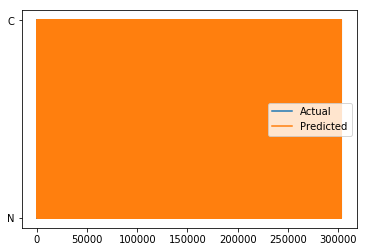

In [22]:
# status, artifact = ds.run_model("Cleaned_Crime_Reports_Full_2.csv", model)
# sleep(1)
# ds.wait_for_job(artifact['job_name'])

# status, prediction = ds.download_artifact(artifact['artifact_name'])
# print(prediction.head())

# unq = prediction[target].unique()[::-1]
# p = np.zeros((len(prediction),))
# a = np.zeros((len(prediction),))
# for i,q in enumerate(unq):
#     p += i*(prediction[target] == q).values
#     a += i*(dataset[target] == q).values
# #Plot predictions vs actual
# plt.plot(a)
# plt.plot(p)
# plt.legend(['Actual','Predicted'])
# plt.yticks([i for i in range(len(unq))],[q for q in unq]);
# print(classification_report(dataset[target], prediction[target]))

#Upload Test Data
status, message = ds.delete_dataset("Cleaned_Crime_Reports_Test.csv")
print(status, message)
status, dataset = ds.upload_dataset("Cleaned_Crime_Reports_Test.csv")
if not status:
    print(dataset)
    
#Clean Test Data
status, job_id = ds.clean_data("Cleaned_Crime_Reports_Test.csv", target = target, model_name = model)
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)
    
#Run Model on Test Data
status, artifact = ds.run_model("Cleaned_Crime_Reports_Test.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv("Cleaned_Crime_Reports_Test.csv")
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))

In [23]:
status, model_type = ds.lookup_model_name(model)
print(model_type['description']['best_genome'])

{'type': 'XGBClassifier', 'parameters': {'base_score': 0.5, 'colsample_bylevel': 1, 'colsample_bytree': 1, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'n_jobs': -1, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'subsample': 1.0}}


In [24]:
# Train some more
status, job_id = ds.resume_training_model(dataset_names = "Cleaned_Crime_Reports_Train.csv",
                                          model_name = model,
                                          max_train_time = '00:10')
                                          
if status:
    ds.wait_for_job(job_id['job_name'])
else:
    print(job_id)

{'status': 'Requested', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': None}
{'status': 'Running', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 0, 'job_type': 'UpdateModel', 'loss': None, 'generations': 0, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:22:10.1

{'status': 'Running', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 25, 'job_type': 'UpdateModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 25, 'job_type': 'UpdateModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:22:10.13842', 'endtime': None, 'percent_complete': 25, 'job_type': 'UpdateModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Train.csv'], 'artifact_names': None, 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime':

{'status': 'Running', 'starttime': '2019-04-19T22:34:55.876776', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['eca3924298a348e791fdc05fbf0476d4'], 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Running', 'starttime': '2019-04-19T22:34:55.876776', 'endtime': None, 'percent_complete': 0, 'job_type': 'RunModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['eca3924298a348e791fdc05fbf0476d4'], 'model_name': 'Clearance Status_model220190419212740', 'job_error': ''}
{'status': 'Complete', 'starttime': '2019-04-19T22:34:55.876776', 'endtime': '2019-04-19T22:35:13.653459', 'percent_complete': 100, 'job_type': 'RunModel', 'loss': 9000000000.0, 'generations': 1, 'dataset_names': ['Cleaned_Crime_Reports_Test.csv'], 'artifact_names': ['eca3924298a348e791fdc05fbf0476d

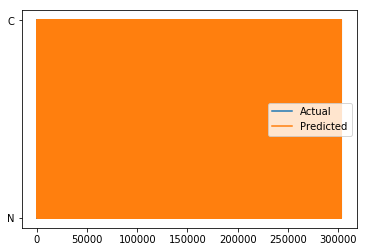

In [25]:
#Run Model on Test Data
status, artifact = ds.run_model("Cleaned_Crime_Reports_Test.csv", model)
sleep(1)
ds.wait_for_job(artifact['job_name'])

status, prediction = ds.download_artifact(artifact['artifact_name'])
df = pd.read_csv("Cleaned_Crime_Reports_Test.csv")
unq = prediction[target].unique()[::-1]
p = np.zeros((len(prediction),))
a = np.zeros((len(prediction),))
for i,q in enumerate(unq):
    p += i*(prediction[target] == q).values
    a += i*(df[target] == q).values
#Plot predictions vs actual
plt.plot(a)
plt.plot(p)
plt.legend(['Actual','Predicted'])
plt.yticks([i for i in range(len(unq))],[q for q in unq]);
print(classification_report(df[target], prediction[target]))